In [15]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/rdgao/documents/Code/research/neurodsp/')

### TL;DR:
Fourier power is distributed via gamma distribution because it is a sum of squares of 2 Gaussian variables ($R^2$ or $C^1$), and the total variance equals to the signal power at that frequency, by definition.
https://math.stackexchange.com/questions/656762/distribution-of-the-sum-of-squared-independent-normal-random-variables

Hence, signal power at each frequency is distributed via chi-squared distribution with k degrees of freedom, where k=2.

(Further, total signal power is a sum of chi-squared distributions: https://en.wikipedia.org/wiki/Chi-squared_distribution#Additivity. And signal amplitude follows a chi distribution: https://math.stackexchange.com/questions/1059938/whats-the-expectation-of-square-root-of-chi-square-variable)

Chi-squared distribution with a degree of freedom k=2 is equivalent to an exponential distribution. 

#### Therefore, spectral power of pure (white) noise should be distributed via an exponential distribution, parametrized by the scale parameter lambda, where for the white noise case, lambda is constant over all frequencies and is a constant of the signal variance in time domain, i.e.

$P(f) ~ exp(lambda)$ where, $1/lambda = var/n_{freqs}$

The Maximum Likelihood Estimate of lambda inverse, given an empirical distribution, is simply the mean.

### We characterize here the standard deviation of sample mean of Gaussian white noise
Per Wikipedia & Wolfram Alpha, sample variance of samples drawn from a normal distribution follows a scaled chi-squared distribution. Since power is conserved as per Parceval's theorem, Fourier power should be distributed similarly?

We can test that by first simulating a number of white noise (normally distributed) time series.

In [2]:
mu = 0
sigma = 6.
n_samples = 1000
n_trials = 4000
X = np.random.randn(n_samples, n_trials)*sigma + mu  # 4000 trials of 1000 random samples each
P = np.abs(sp.fft(X, n=n_samples, axis=0)/n_samples) # compute their amplitude

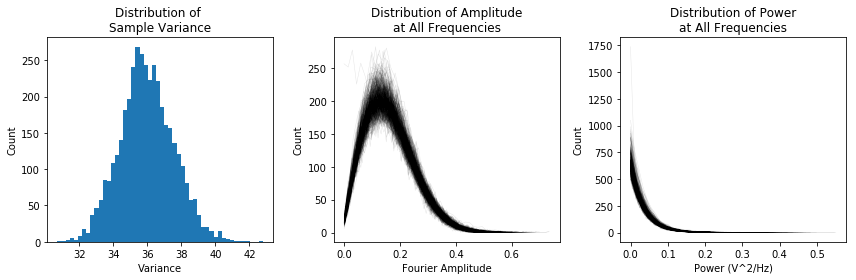

In [4]:
hist_logged = False
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(np.var(X,axis=0), bins=50);
plt.xlabel('Variance')
plt.ylabel('Count')
plt.title('Distribution of \nSample Variance')

plt.subplot(1,3,2)
for i in range(int(n_samples/2)):
    if not hist_logged:
        counts, bins = np.histogram(P[i,:], bins=50)
    else:
        counts, bins = np.histogram(np.log10(P[i,:]), bins=50)
    plt.plot(bins[:-1], counts, 'k', lw=0.5, alpha=0.1)

plt.xlabel('Fourier Amplitude')
plt.ylabel('Count')
plt.title('Distribution of Amplitude\nat All Frequencies');

plt.subplot(1,3,3)
for i in range(int(n_samples/2)):
    if not hist_logged:
        counts, bins = np.histogram(P[i,:]**2., bins=50)
    else:
        counts, bins = np.histogram(np.log10(P[i,:]**2), bins=50)
    plt.plot(bins[:-1], counts, 'k', lw=0.5, alpha=0.1)

plt.xlabel('Power (V^2/Hz)')
plt.ylabel('Count')
plt.title('Distribution of Power\nat All Frequencies');
plt.tight_layout()

Well that clearly did not work. Power at each frequency is not distributed in the same way as the sample variance, but rather a chi-squared/exponential-ish (maybe gamma?) distribution. Why??

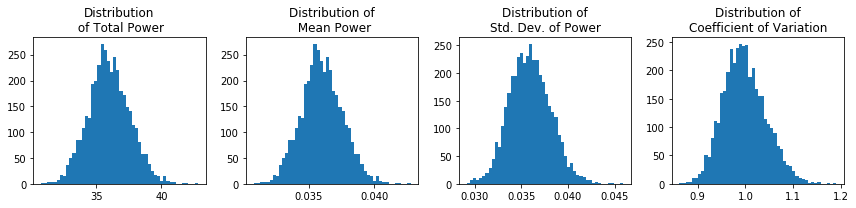

In [5]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.hist(np.sum(P**2., axis=0), bins=50);
plt.title('Distribution\n of Total Power')

plt.subplot(1,4,2)
plt.hist(np.mean(P**2., axis=0), bins=50);
plt.title('Distribution of\n Mean Power')

plt.subplot(1,4,3)
plt.hist(np.std(P**2., axis=0), bins=50);
plt.title('Distribution of\nStd. Dev. of Power')

plt.subplot(1,4,4)
plt.hist(np.std(P**2., axis=0)/np.mean(P**2., axis=0), bins=50);
plt.title('Distribution of\nCoefficient of Variation')

plt.tight_layout()

- Power distribution is almost identical to variance distribution above, as expected.
- Distribution of mean power is the same as distribution of total power, obviously, just scaled by # of frequencies (1000).
- Distribution of std dev of power, however, is centered around the same mean as the means, as predicted by the derivation in http://www.laurent-duval.eu/Documents-Common/Schuster_G_2010_lect_spectrum_upbw.pdf, page 19
- https://dsp.stackexchange.com/questions/40086/frequency-magnitude-distribution-of-noise
- unsurprisingly, SCV (4th) is centered around 1.

Let's fit the power distribution at each frequency with a gamma distribution.
- https://stackoverflow.com/questions/16963415/why-does-the-gamma-distribution-in-scipy-have-three-parameters
- https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy
- https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.gamma.html

In [6]:
print(np.shape(P))

(1000, 4000)


In [7]:
params = []
for i in range(1,int(n_samples/2)): # skip 0 Hz
    params_ = sp.stats.gamma.fit(P[i,:]**2., floc=0.)
    params.append(params_)

Shape:  1.0007459959424625 
Scale:  0.035991351183042655


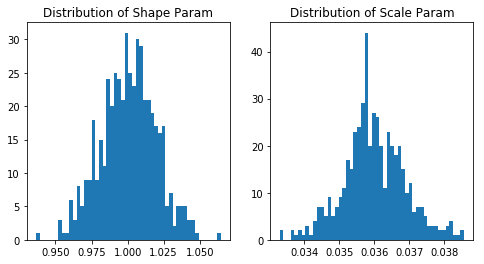

In [9]:
p_shape = [p[0] for p in params]
p_scale = [p[2] for p in params]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(p_shape, bins=50)
plt.title('Distribution of Shape Param')
plt.subplot(1,2,2)
plt.hist(p_scale, bins=50)
plt.title('Distribution of Scale Param')
print('Shape: ', np.mean(p_shape), '\nScale: ', np.mean(p_scale))

Gamma oscillation fits well, with the expected params k=1 and theta=0.036.

Text(0.5,15,'Energy (V$^2$)')

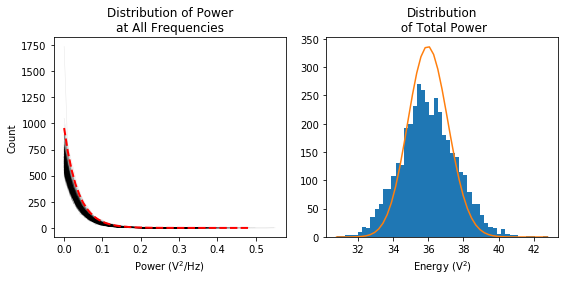

In [10]:
shape = 1.
scale = 0.036

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for i in range(int(n_samples/2)):
    if not hist_logged:
        counts, bins = np.histogram(P[i,:]**2., bins=50)
    else:
        counts, bins = np.histogram(np.log10(P[i,:]**2), bins=50)
    plt.plot(bins[:-1], counts, 'k', lw=0.5, alpha=0.1)


gamma_pdf = sp.stats.gamma.pdf(bins[:-1], shape, scale=scale)
plt.plot(bins[:-1], gamma_pdf/np.sum(gamma_pdf)*np.sum(counts), '--r', lw=2)
plt.xlabel('Power (V$^2$/Hz)')
plt.ylabel('Count')
plt.title('Distribution of Power\nat All Frequencies');

plt.subplot(1,2,2)
counts, bins, _ = plt.hist(np.sum(P**2., axis=0), bins=50);
gamma_pdf = sp.stats.gamma.pdf(bins, shape*1000., scale=0.036) # sum of gamma fit
plt.plot(bins, gamma_pdf/np.sum(gamma_pdf)*np.sum(counts)) 
plt.title('Distribution\n of Total Power')
plt.tight_layout()
plt.xlabel('Energy (V$^2$)')


Fit the observed distributions of power with a gamma distribution (left), which fits well. But fitting the total power distribution with the theoretical sum of gamma does not seem to fit well?
- https://en.wikipedia.org/wiki/Gamma_distribution#Summation
- https://stats.stackexchange.com/questions/51605/the-sum-of-two-independent-gamma-random-variables

Does the gamma distribution come from a sum of squared values from the real + imag components of the Fourier coefficients?

In [11]:
F = sp.fft(X, n=n_samples, axis=0)/n_samples # compute their Fourier Coefficients
F_real = np.real(F)
F_imag = np.imag(F)

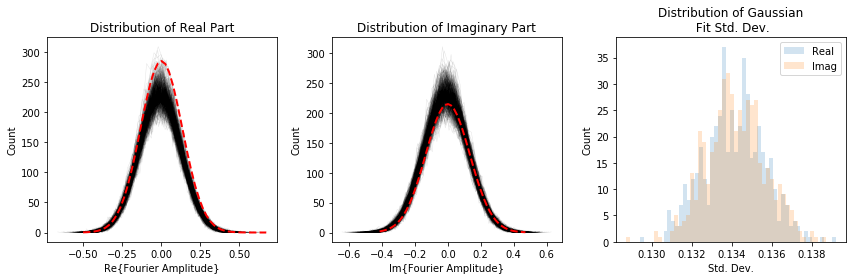

In [13]:
params_re = []
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
for i in range(1, int(n_samples/2)):
    counts, bins = np.histogram(F_real[i,:], bins=50)
    plt.plot(bins[:-1], counts, 'k', lw=0.5, alpha=0.1)
    params_ = sp.stats.norm.fit(F_real[i,:], floc=0.)
    params_re.append(params_)

normal_pdf = sp.stats.norm.pdf(bins[:-1], scale=np.mean([p[1] for p in params_re[1:]]))
plt.plot(bins[:-1], normal_pdf/np.sum(normal_pdf)*np.sum(counts), 'r--', lw=2)
plt.xlabel('Re{Fourier Amplitude}')
plt.ylabel('Count')
plt.title('Distribution of Real Part');

params_im = []
plt.subplot(1,3,2)
for i in range(1, int(n_samples/2)):
    counts, bins = np.histogram(F_imag[i,:], bins=50)
    plt.plot(bins[:-1], counts, 'k', lw=0.5, alpha=0.1)
    params_ = sp.stats.norm.fit(F_imag[i,:], floc=0.)
    params_im.append(params_)

normal_pdf = sp.stats.norm.pdf(bins[:-1], scale=np.mean([p[1] for p in params_im[1:]]))
plt.plot(bins[:-1], normal_pdf/np.sum(normal_pdf)*np.sum(counts), 'r--', lw=2)
plt.xlabel('Im{Fourier Amplitude}')
plt.ylabel('Count')
plt.title('Distribution of Imaginary Part');

plt.subplot(1,3,3)
# skip 0Hz
plt.hist([p[1] for p in params_re[1:]], bins = 50, alpha=0.2)
plt.hist([p[1] for p in params_im[1:]], bins = 50, alpha=0.2)
plt.xlabel('Std. Dev.')
plt.ylabel('Count')
plt.title('Distribution of Gaussian\n Fit Std. Dev.');
plt.legend(('Real', 'Imag'))

plt.tight_layout()

In [14]:
sig_re = np.mean([p[1] for p in params_re[1:]])
sig_im = np.mean([p[1] for p in params_im[1:]])
print('Sigma Real: ', sig_re, 'Sigmal Imag:', sig_im)
print('Sigma Square:', sig_re**2+sig_im**2)

Sigma Real:  0.13411163749004806 Sigmal Imag: 0.1342125025367838
Sigma Square: 0.03599892714744826


### In summary:
Fourier power is distributed via gamma distribution because it is a sum of squares of 2 Gaussian variables ($R^2$ or $C^1$), and the total variance equals to the signal power at that frequency, by definition.
https://math.stackexchange.com/questions/656762/distribution-of-the-sum-of-squared-independent-normal-random-variables

Hence, signal power at each frequency is distributed via chi-squared distribution with k degrees of freedom, where k=2.

(Further, total signal power is a sum of chi-squared distributions: https://en.wikipedia.org/wiki/Chi-squared_distribution#Additivity. And signal amplitude follows a chi distribution: https://math.stackexchange.com/questions/1059938/whats-the-expectation-of-square-root-of-chi-square-variable)

Chi-squared distribution with a degree of freedom k=2 is equivalent to an exponential distribution. 

#### Therefore, spectral power of pure (white) noise should be distributed via an exponential distribution, parametrized by the scale parameter lambda, where for the white noise case, lambda is constant over all frequencies and is a constant of the signal variance in time domain, i.e.

$P(f) ~ exp(lambda)$ where, $1/lambda = var/n_{freqs}$

The Maximum Likelihood Estimate of lambda inverse, given an empirical distribution, is simply the mean.